In [1]:
import array
import math
import datetime as dt
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

import matplotlib.pylab as plt

In [ ]:
beta = 0.7


def DDVanillaCall(F, beta, K, r, sigma, T):
    d1 = ((beta*sigma)**2 * T - 2*np.log(beta*K/F + (1-beta))) / (2*beta*sigma*np.sqrt(T))
    d2 = (-(beta*sigma)**2 * T - 2*np.log(beta*K/F + (1-beta))) / (2*beta*sigma*np.sqrt(T))
    return (F/beta)*np.exp(-r*T)*norm.cdf(d1) - ((1-beta)/beta * F + K)*np.exp(-r*T)*norm.cdf(d2)


def DDVanillaPut(F, beta, K, r, sigma, T):
    d1 = ((beta*sigma)**2 * T - 2*np.log(beta*K/F + (1-beta))) / (2*beta*sigma*np.sqrt(T))
    d2 = (-(beta*sigma)**2 * T - 2*np.log(beta*K/F + (1-beta))) / (2*beta*sigma*np.sqrt(T))
    return (-F/beta)*np.exp(-r*T)*norm.cdf(-d1) + ((1-beta)/beta * F + K)*np.exp(-r*T)*norm.cdf(-d2)


def DDVanilla(F, beta, K, r, sigma, T, cp_flag):
    if cp_flag == 'C':
        return DDVanillaCall(F, beta, K, r, sigma, T)
    else:
        return DDVanillaPut(F, beta, K, r, sigma, T)

def impliedVolatility_DD(F, beta, K, r, price, T, cp_flag):
    try:
        if (cp_flag == 'C'):
            impliedVol = brentq(lambda x: price -
                                DDVanillaCall(F, beta, K, r, x, T),
                                1e-12, 10.0)
        elif (cp_flag == 'P'):
            impliedVol = brentq(lambda x: price -
                                DDVanillaPut(F, beta, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception as ex:
        print(ex)
        impliedVol = np.nan

    return impliedVol


def DDcalibration(x, df):   
    err = 0
    
    for i in range(len(df.index)):
        if (df['cp_flag'].iloc[i] == 'C'):
            err += (df['price'].iloc[i] -
                    DDVanillaCall(df['F'].iloc[i], x[0],
                                  df['strike'].iloc[i],
                                  df['r'].iloc[i],
                                  x[1], df['T'].iloc[i]))**2
        
        elif (df['cp_flag'].iloc[i] == 'P'):
            err += (df['price'].iloc[i] -
                    DDVanillaPut(df['F'].iloc[i], x[0],
                                 df['strike'].iloc[i],
                                 df['r'].iloc[i],
                                 x[1], df['T'].iloc[i]))**2

    return err


def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):      
    errors = []
    for i, vol in enumerate(vols):
        errors.append((vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2)

    return sum(errors)


def impliedVolatility(S, K, r, price, T, payoff, exercise_style):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            # Use binomial tree to price american puts
            if exercise_style == 'A':
                steps = 150
                impliedVol = brentq(lambda x: price -
                                american_put(S, K, r, x, T, steps),
                                1e-12, 10.0)
            else:
                impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception as ex:
        print(ex)
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]
    
    
def get_rf_rate(T, rates_df):
    days_till_expiry = T * 365
    # TODO: It looks like the 1st 2 values should start with 0.2 instead of 0.1? 
    for i, row in rates_df.iterrows():
        if days_till_expiry < row['days']:
            prev_rate = rates_df.iloc[i - 1]['rate'] if i != 0 else 0
            rate = row['rate']
            prev_days = rates_df.iloc[i - 1]['rate'] if i != 0 else 0
            days = row['days']
            
            return (prev_rate +
                (rate - prev_rate) * (days_till_expiry - prev_days) / (days - prev_days))
    
    return rates_df.iloc[-1]['rate']


def find_atm_vol(df, F):
    df_sorted_by_K = df.sort_values('strike')
    # Find first row where F is larger than K
    first_match = df_sorted_by_K[F < df['strike']].iloc[0]
    
    return first_match['impliedvol']


def transform_data(df, S, rates_df):
    df['date'] =  pd.to_datetime(df['date'], format='%Y%m%d')
    df['exdate'] =  pd.to_datetime(df['exdate'], format='%Y%m%d')
    df['T'] = (df['exdate'] - df['date']).dt.days / 365 # Prof picks 365 days instead of 252 days in his notebook
    df['strike'] = df['strike_price'] / 1000
    df['payoff'] = np.where(df['cp_flag'] == 'C', 'call', 'put')
    df['price'] = (df['best_bid'] + df['best_offer']) / 2
        
    # Linearly extrapolate rates
    rates_df['T'] = rates_df['days'] / 365.0
    f = interp1d(rates_df['T'], rates_df['rate'] / 100)
    df['r'] = f(df['T'])
    df['S'] = S
    df['F'] = S * np.exp(df['r'] * df['T'])
    
    # Only use OTM calls and puts
    df = df[((df.payoff == "call") & (df.strike > df.F)) | ((df.payoff == "put") & (df.strike < df.F))]
    
    
    df['impliedvol'] = df.apply(
        lambda x: impliedVolatility(S, x['strike'], x['r'], x['price'], x['T'], x['payoff'], x['exercise_style']),
        axis=1
    )
    
    return df

In [20]:
def get_options_data():
    spx_price = 3662.45
    spy_price = 366.02
    
    spx_df = pd.read_csv('SPX_options.csv')
    spy_df = pd.read_csv('SPY_options.csv')
    rates_df = pd.read_csv('zero_rates_20201201.csv')
    
    spx_df = transform_data(spx_df, spx_price, rates_df)
    spy_df = transform_data(spy_df, spy_price, rates_df)
    
    return spx_df, spy_df

def calibrate(df, F, T):
    initialGuess = [0.02, -0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'].reset_index(drop=True),
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))
    return {
        'F': F,
        'T': T,
        'alpha': alpha,
        'beta': beta,
        'rho': rho,
        'nu': nu,
    }


### Load and transform data

In [21]:
spx_df, spy_df = get_options_data()
options_data = {
    'SPX': spx_df,
    'SPY': spy_df
}

<ipython-input-19-5774ebbf4d82>:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['impliedvol'] = df.apply(
<ipython-input-19-5774ebbf4d82>:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['impliedvol'] = df.apply(


## Displaced Diffusion Calibration

Processing SPY
Calibrated DD model parameters for 2020-12-18 00:00:00: beta = 0.36441, sigma = 0.19364 

Calibrated DD model parameters for 2021-01-15 00:00:00: beta = 0.33483, sigma = 0.19420 

Calibrated DD model parameters for 2021-02-19 00:00:00: beta = 0.30735, sigma = 0.20277 



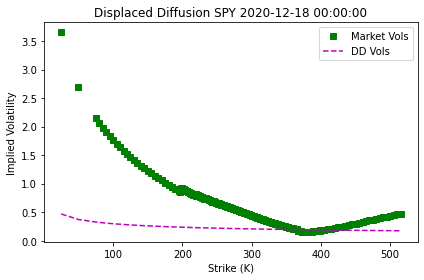

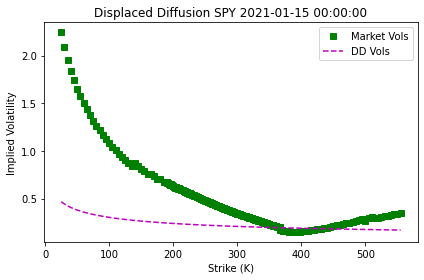

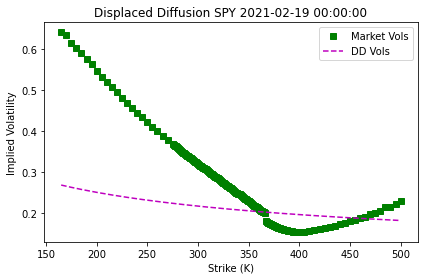

In [23]:
for dataset, options_df in options_data.items():
    print('Processing', dataset)
    dd_results = {}

    for expiry_date, df in options_df.groupby('exdate'):
        dd_df = df[df['best_bid'] > 0]

        initialGuess = [0.4, 0.5]
        res = least_squares(lambda x: DDcalibration(x, dd_df),
                            initialGuess)

        beta = res.x[0]
        sigma = res.x[1]

        print('Calibrated DD model parameters for %s: beta = %.5f, sigma = %.5f \n' % (expiry_date, beta, sigma))

        dd_results[expiry_date] = {
            'dd': {'beta': beta, 'sigma': sigma},
            'df': df
        }
    
    for expiry_date, results in dd_results.items():
        params = results['dd']
        df = results['df'].sort_values('strike')
        T = df.iloc[0]['exdate']

        # Calculate Displace Diffusion price
        df['ddprice'] = df.apply(
            lambda x: DDVanilla(x['F'], params['beta'], x['strike'], x['r'], params['sigma'], x['T'], x['cp_flag']), axis=1)

        # Get BS vol for this price assuming european option
        df['ddvol'] = df.apply(
            lambda x: impliedVolatility(x['S'], x['strike'], x['r'], x['ddprice'], x['T'], x['payoff'], 'E'),
            axis=1
        )

        plt.figure(tight_layout=True)

        plt.plot(df['strike'], df['impliedvol'], 'gs', label='Market Vols')
        plt.plot(df['strike'], df['ddvol'], 'm--', label='DD Vols')

        plt.title('Displaced Diffusion {} {}'.format(dataset, expiry_date))
        plt.xlabel('Strike (K)')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.show()

## SABR Calibration

Processing SPX
2020-12-18 00:00:00 3662.664084743022


<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.898, beta = 0.7, rho = -0.520, nu = 4.210
2021-01-15 00:00:00 3663.3762493669747


<ipython-input-10-bc134d281aad>:177: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_match = df_sorted_by_K[F < df['strike']].iloc[0]


Calibrated SABR model parameters: alpha = 2.137, beta = 0.7, rho = -0.601, nu = 2.267
2021-02-19 00:00:00 3664.221472703759


<ipython-input-10-bc134d281aad>:177: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_match = df_sorted_by_K[F < df['strike']].iloc[0]


Calibrated SABR model parameters: alpha = 2.214, beta = 0.7, rho = -0.614, nu = 1.744


<ipython-input-10-bc134d281aad>:177: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_match = df_sorted_by_K[F < df['strike']].iloc[0]


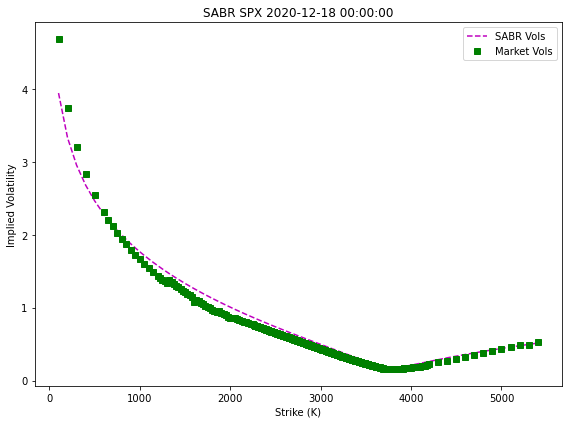

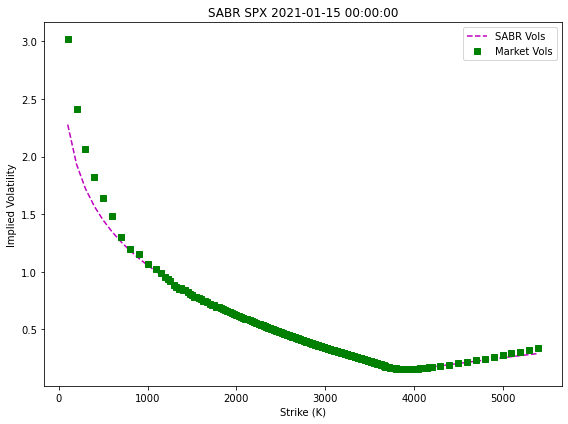

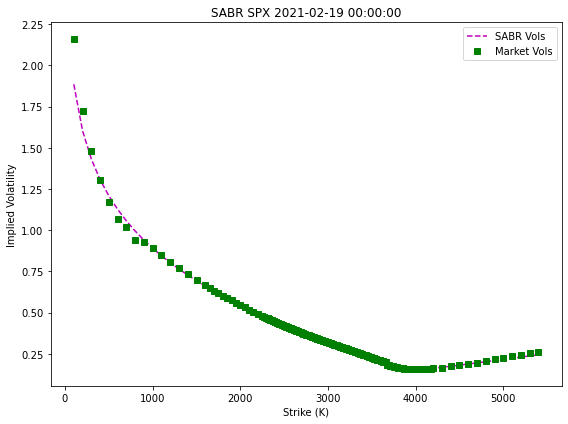

Processing SPY
2020-12-18 00:00:00 366.0413953221589


<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 0.941, beta = 0.7, rho = -0.540, nu = 4.682
2021-01-15 00:00:00 366.11256803322914


<ipython-input-10-bc134d281aad>:177: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_match = df_sorted_by_K[F < df['strike']].iloc[0]
<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.015, beta = 0.7, rho = -0.573, nu = 2.610
2021-02-19 00:00:00 366.1970384412155


<ipython-input-10-bc134d281aad>:177: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_match = df_sorted_by_K[F < df['strike']].iloc[0]
<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
<ipython-input-10-bc134d281aad>:73: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.103, beta = 0.7, rho = -0.635, nu = 1.852


<ipython-input-10-bc134d281aad>:177: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_match = df_sorted_by_K[F < df['strike']].iloc[0]


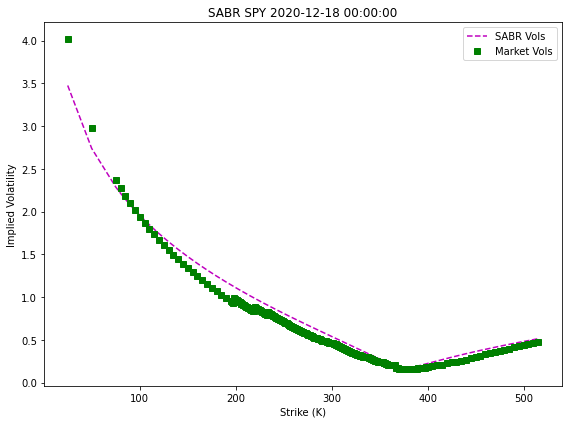

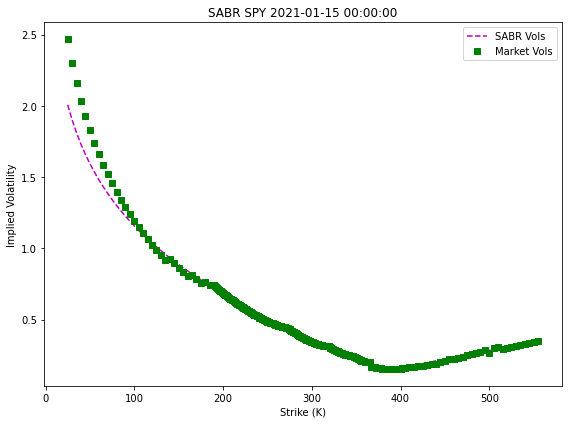

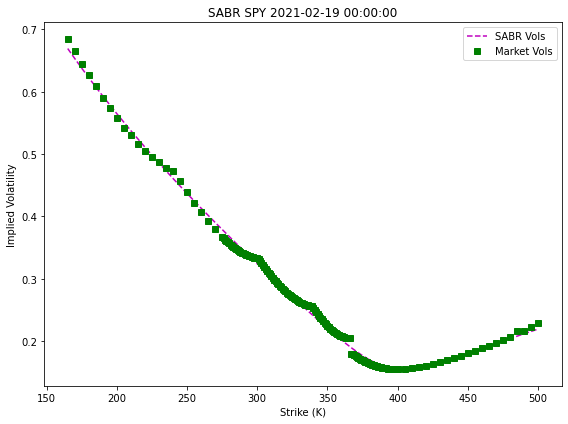

In [14]:
for dataset, options_df in options_data.items():
    print('Processing', dataset)
    sabr_results = {}

    for expiry_date, df in options_df.groupby('exdate'):
        T = df.iloc[0]['T']
        F = df.iloc[0]['F']
        print(expiry_date, F)

        # Get rid of strikes that do not have a valid bid when calibrating otherwise it skews data
        sabr_df = df[df['best_bid'] > 0]
        sabr_calibration = calibrate(sabr_df, F, T)
        atmvol = find_atm_vol(df, F)

        sabr_results[expiry_date] = {
            'sabr': sabr_calibration,
            'df': df,
            'atmvol': atmvol
        }

    # Plot SABR and market vols
    for expiry_date, results in sabr_results.items():
        r = results['sabr']
        df = results['df'].sort_values('strike')
        strikes = df['strike']

        sabrvols = []
        for K in strikes:
            sabrvols.append(SABR(r['F'], K, T, r['alpha'], r['beta'], r['rho'], r['nu']))

        plt.figure(tight_layout=True, figsize=(8, 6))
        plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
        plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
        plt.title('SABR {} {}'.format(dataset, expiry_date))
        plt.xlabel('Strike (K)')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.show()

